In [2]:
# ds_notebook_1.ipynb
# Google Colab notebook for Data Science Assignment (Web3 Trading Team)

# ====================
# 1. Setup & Imports
# ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plots
plt.style.use('default')
sns.set_theme()

In [3]:
# ====================
# 2. Load Data
# ====================
# Paths: adjust if needed (upload or mount drive)
fg = pd.read_csv('/content/drive/MyDrive/ds_Akshat_Mishra/csv_files/fear_greed_index.csv', parse_dates=['date'])
hist = pd.read_csv('/content/drive/MyDrive/ds_Akshat_Mishra/csv_files/historical_data.csv', low_memory=False)

print("Fear/Greed shape:", fg.shape)
print("Historical shape:", hist.shape)

# Preview
fg.head(), hist.head()

Fear/Greed shape: (2644, 4)
Historical shape: (211224, 16)


(    timestamp  value classification       date
 0  1517463000     30           Fear 2018-02-01
 1  1517549400     15   Extreme Fear 2018-02-02
 2  1517635800     40           Fear 2018-02-03
 3  1517722200     24   Extreme Fear 2018-02-04
 4  1517808600     11   Extreme Fear 2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12

In [4]:
# ====================
# 3. Parse timestamps & create join key
# ====================
hist['Timestamp_dt'] = pd.to_datetime(hist['Timestamp'], unit='ms', errors='coerce')
hist['Timestamp_IST_dt'] = pd.to_datetime(hist['Timestamp IST'], dayfirst=True, errors='coerce')

# create date column
hist['date'] = hist['Timestamp_dt'].dt.date
fg['date'] = pd.to_datetime(fg['date']).dt.date


In [5]:
# ====================
# 4. Basic EDA
# ====================
print("Fear/Greed classifications:")
print(fg['classification'].value_counts())

print("Historical nulls:")
print(hist.isna().mean().sort_values(ascending=False).head(10))

# PnL stats
print("Closed PnL stats:")
print(hist['Closed PnL'].describe())

# Trade counts by date
print("Trade counts by date:")
print(hist['date'].value_counts().sort_index())

Fear/Greed classifications:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64
Historical nulls:
Account            0.0
Coin               0.0
Execution Price    0.0
Size Tokens        0.0
Size USD           0.0
Side               0.0
Timestamp IST      0.0
Start Position     0.0
Direction          0.0
Closed PnL         0.0
dtype: float64
Closed PnL stats:
count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64
Trade counts by date:
date
2023-03-28         3
2023-11-14      1045
2024-03-09      6962
2024-07-03      7141
2024-10-27     35241
2025-02-19    133871
2025-06-15     26961
Name: count, dtype: int64


In [6]:
# ====================
# 5. Merge datasets
# ====================
merged_trades = hist.merge(fg[['date','classification','value']], on='date', how='left')
merged_trades['classification'].fillna('No Sentiment', inplace=True)

print("Classification coverage in trades:")
print(merged_trades['classification'].value_counts())

Classification coverage in trades:
classification
Fear             133871
Greed             36289
No Sentiment      26961
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64


/tmp/ipython-input-635471368.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_trades['classification'].fillna('No Sentiment', inplace=True)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


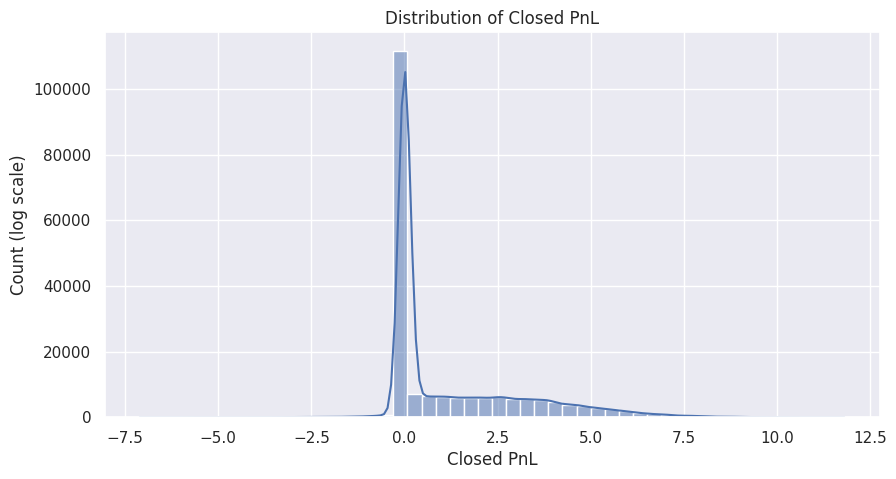

In [12]:
# ====================
# 6. Visualizations
# ====================
# Distribution of PnL
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(merged_trades['Closed PnL']), bins=50, kde=True)
plt.title('Distribution of Closed PnL')
plt.xlabel('Closed PnL')
plt.ylabel('Count (log scale)')
# plt.xlim(-10, 50)
plt.savefig('/content/drive/MyDrive/ds_Akshat_Mishra/outputs/distribution_pnl.png', bbox_inches='tight')
plt.show()


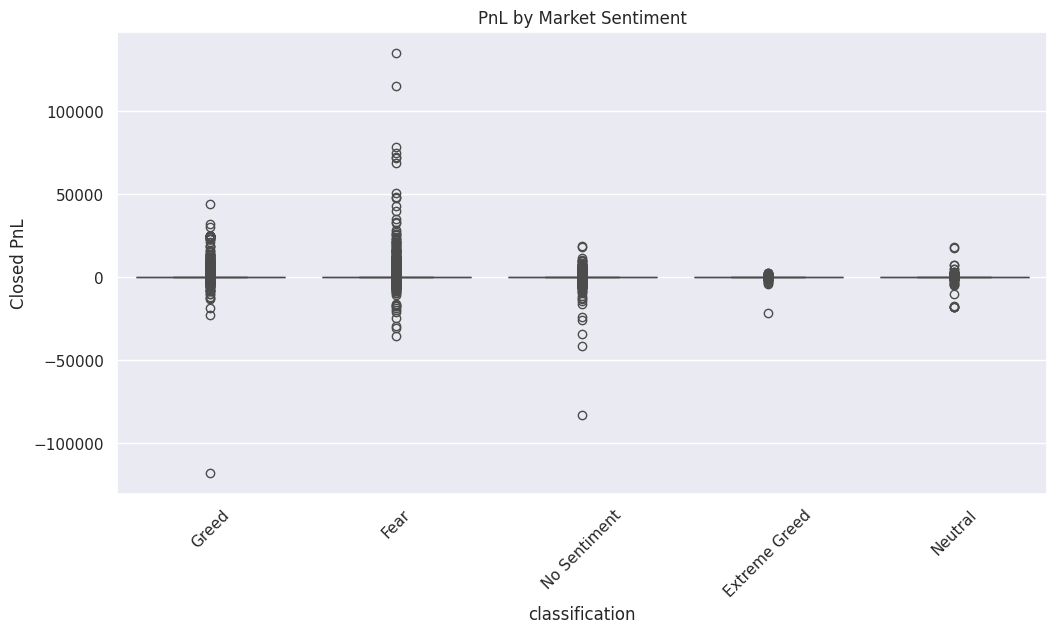

In [13]:
# Boxplot of PnL by classification
plt.figure(figsize=(12,6))
sns.boxplot(x='classification', y='Closed PnL', data=merged_trades)
plt.xticks(rotation=45)
plt.title('PnL by Market Sentiment')
plt.savefig('/content/drive/MyDrive/ds_Akshat_Mishra/outputs/pnl_by_sentiment_boxplot.png', bbox_inches='tight')
plt.show()

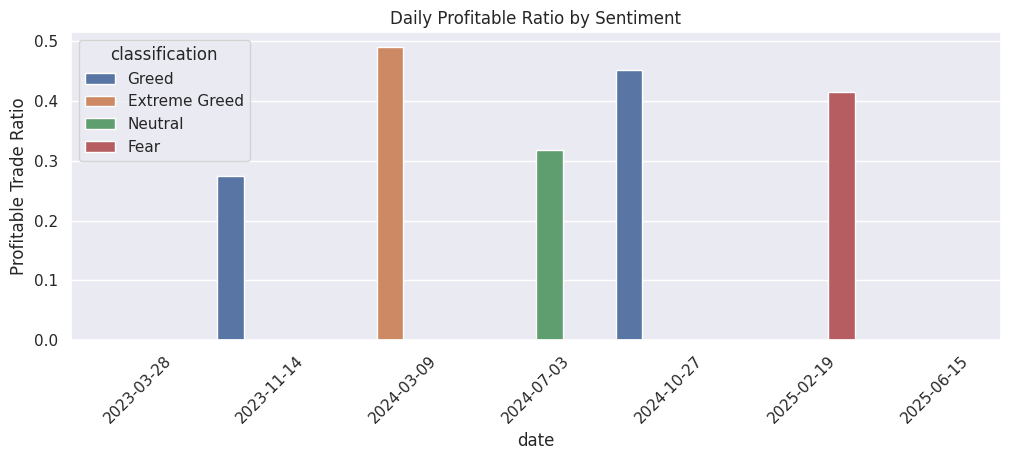

In [15]:
# ====================
# 7. Daily Aggregation
# ====================
daily = merged_trades.groupby('date').agg(
    trades_count=('Trade ID','count'),
    total_notional_usd=('Size USD','sum'),
    avg_pnl=('Closed PnL','mean'),
    median_pnl=('Closed PnL','median'),
    profitable_trades=('Closed PnL', lambda x: (x>0).sum())
).reset_index()

daily['profitable_ratio'] = daily['profitable_trades'] / daily['trades_count']
daily = daily.merge(fg[['date','classification','value']], on='date', how='left')

# Save to CSV
daily.to_csv('/content/drive/MyDrive/ds_Akshat_Mishra/csv_files/daily_aggregates.csv', index=False)

# Plot daily profitable ratio
plt.figure(figsize=(12,4))
sns.barplot(x='date', y='profitable_ratio', hue='classification', data=daily)
plt.xticks(rotation=45)
plt.title('Daily Profitable Ratio by Sentiment')
plt.ylabel('Profitable Trade Ratio')
plt.savefig('/content/drive/MyDrive/ds_Akshat_Mishra/outputs/daily_profitable_ratio.png', bbox_inches='tight')
plt.show()


In [16]:
# ====================
# 8. Per-account Aggregation
# ====================
acct = merged_trades.groupby('Account').agg(
    total_trades = ('Trade ID','count'),
    total_pnl = ('Closed PnL','sum'),
    avg_pnl = ('Closed PnL','mean'),
    win_rate = ('Closed PnL', lambda x: (x>0).mean())
).reset_index()

acct.to_csv('/content/drive/MyDrive/ds_Akshat_Mishra/csv_files/per_account_summary.csv', index=False)

# Show top profitable accounts
acct.sort_values('total_pnl', ascending=False).head(10)


,Account,total_trades,total_pnl,avg_pnl,win_rate
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14733,2.143383e+06,145.481748,0.337134
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,1.600230e+06,419.127768,0.359612
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,21192,9.401638e+05,44.364091,0.467582
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,12236,8.404226e+05,68.684419,0.401193
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184,8.360806e+05,20.806305,0.428230
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,4356,6.777471e+05,155.589314,0.486226
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,1590,4.293556e+05,270.034947,0.345912
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1237,4.165419e+05,336.735548,0.484236
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1430,4.030115e+05,281.826227,0.306294
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,9893,3.790954e+05,38.319560,0.810876


In [9]:
# ====================
# 9. Statistical Test Example
# ====================
from scipy.stats import mannwhitneyu

greed_trades = merged_trades[merged_trades['classification'].isin(['Greed','Extreme Greed'])]['Closed PnL']
fear_trades  = merged_trades[merged_trades['classification'].isin(['Fear','Extreme Fear'])]['Closed PnL']

stat, p = mannwhitneyu(greed_trades, fear_trades, alternative='two-sided')
print("Mann-Whitney U test between Greed vs Fear trades:")
print("stat=", stat, "p=", p)



Mann-Whitney U test between Greed vs Fear trades:
stat= 3000278861.5 p= 3.5293405510364374e-34


In [10]:
# ====================
# 10. Save intermediate results & Notes
# ====================
# Make sure outputs folder exists (if not, create manually)
# All charts already saved to outputs/
# CSVs saved to csv_files/

print("Notebook completed successfully. Check csv_files/ and outputs/ for saved artifacts.")


Notebook completed successfully. Check csv_files/ and outputs/ for saved artifacts.
